# Präsenzversuch zum Laval-Rotor

Name: Marius Stumpe 
Datum: 08.02.2024 
Gruppe: 02

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Lassen sich eindeutige kritische Kreisfrequenzen erkennen?

## Erster Versuch: Prüfstand 04
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

![Prüfstand](IMG_9581.jpg)

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

In einer Einhausung befindet sich eine Welle, die durch ein Los- und ein Festlager gehalten wird. Ein Fanglager um die Welle erhöht die Sicherheit des Versuchs. Die Welle ist über einen Motor mit einem Schaltkasten verbunden. Mit Hilfe von drei Beschleunigungssensoren werden die Beschleunigungen und mit einem Hallsensor die Rotationsgeschwindigkeit der Welle gemessen. Neben dem Fanglager an der Welle angebracht, befindet sich eine Scheibe mit dem Gewicht 1 kg.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_153738_lavalrotor_02_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_153738_lavalrotor_02_04.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240115_153738_lavalrotor_02_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)
RPM = []
amplitudes = []
frequencies = []


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions

with h5py.File(path_measurement_folder + "/" + filename, "r") as measurement:
    for i in range(20):
        i = str(i)
        data = m_postprocessing.get_vec_accel(measurement[i]["RawData"][uuid_acceleration]["acceleration_x"], measurement[i]["RawData"][uuid_acceleration]["acceleration_y"], measurement[i]["RawData"][uuid_acceleration]["acceleration_z"])
        interpolated_data = m_postprocessing.interpolation(measurement[i]["RawData"][uuid_acceleration]["timestamp"], data, interpolation_points)
        [amp, freq] = m_postprocessing.my_fft_scaled(interpolated_data, measurement[i]["RawData"][uuid_acceleration]["timestamp"])
        RPM.append(measurement[i]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        amplitudes.append(amp)
        frequencies.append(freq)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

Text(0, 0.5, 'Frequency in Hertz')

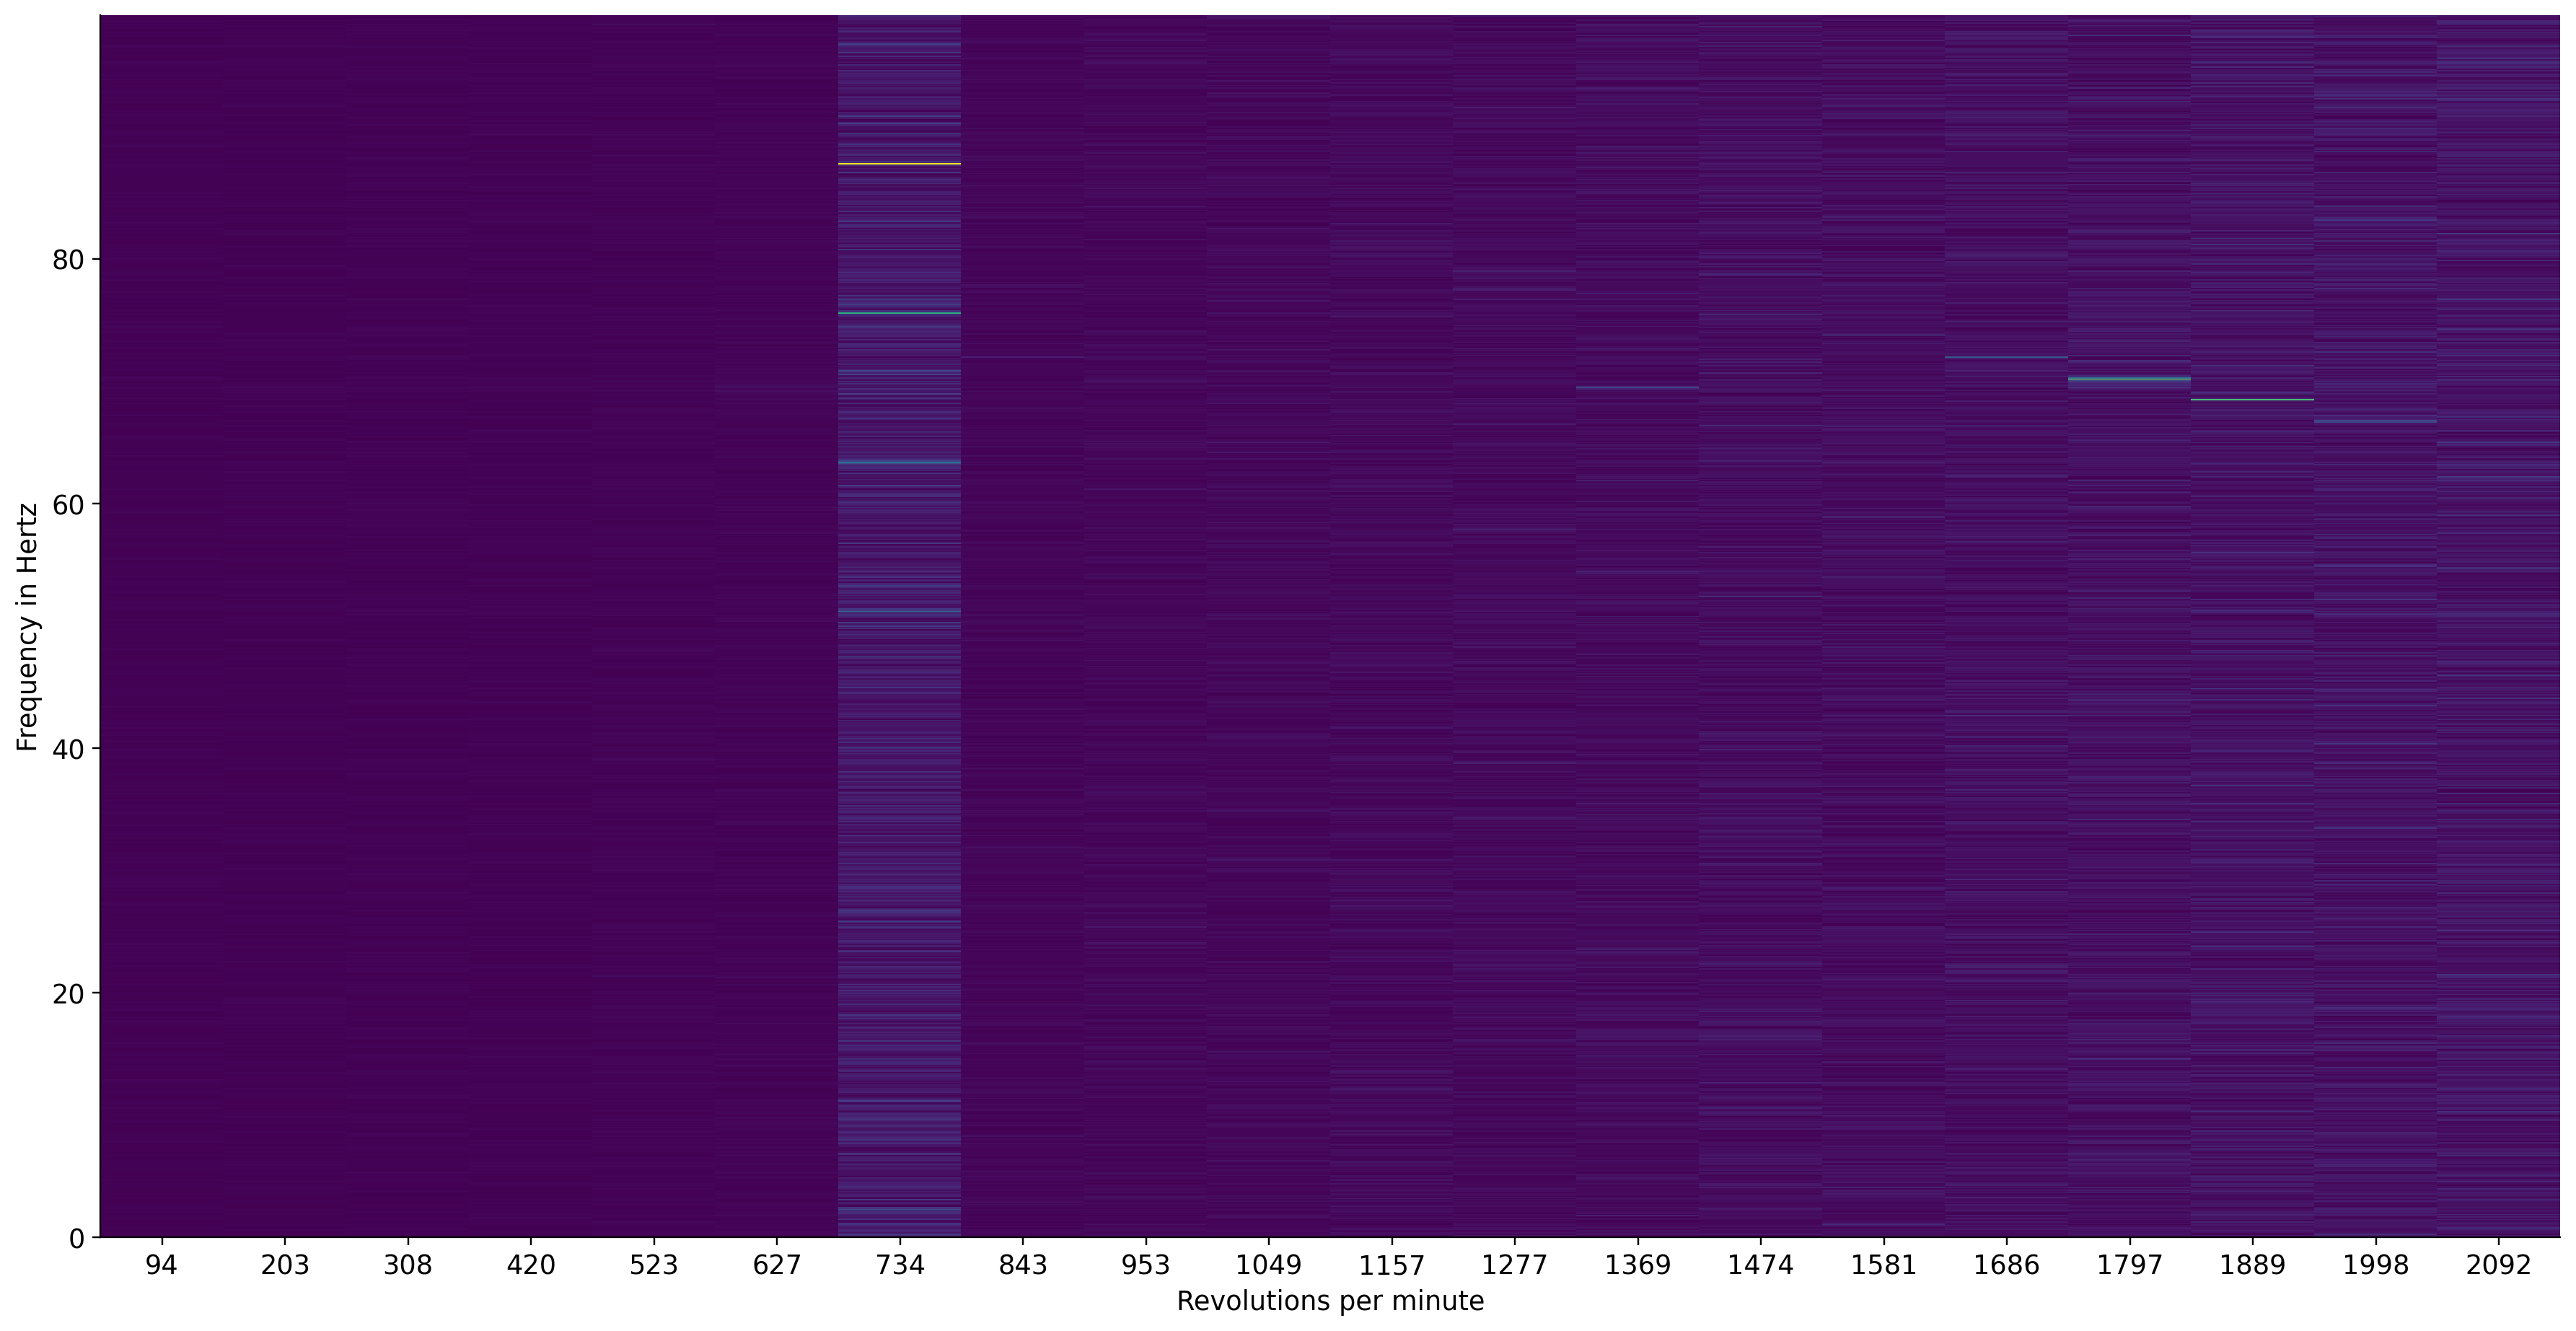

In [6]:
show_amplitudes = []
for i in range(len(amplitudes[0])):
    amplitudes_of_frequency = []    
    for z in range(len(amplitudes)):
        amplitudes_of_frequency.append(amplitudes[z][i])
    show_amplitudes.append(amplitudes_of_frequency)


plt.figure(figsize = (20,10))
plt.imshow(show_amplitudes, extent = (-0.5,len(RPM)-0.5,0,frequencies[len(frequencies)-1][len(frequencies[0])-1]), aspect = "auto", interpolation = "none")
plt.xticks(range(len(RPM)), RPM)
plt.xlabel("Revolutions per minute")
plt.ylabel("Frequency in Hertz")

## Zweiter Datensatz: Prüfstand 02

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)
RPM = []
amplitudes = []
frequencies = []


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  # reload functions

with h5py.File(path_measurement_folder + "/" + filename, "r") as measurement:
    for i in range(20):
        i = str(i)
        data = m_postprocessing.get_vec_accel(measurement[i]["RawData"][uuid_acceleration]["acceleration_x"], measurement[i]["RawData"][uuid_acceleration]["acceleration_y"], measurement[i]["RawData"][uuid_acceleration]["acceleration_z"])
        interpolated_data = m_postprocessing.interpolation(measurement[i]["RawData"][uuid_acceleration]["timestamp"], data, interpolation_points)
        [amp, freq] = m_postprocessing.my_fft_scaled(interpolated_data, measurement[i]["RawData"][uuid_acceleration]["timestamp"])
        RPM.append(measurement[i]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        amplitudes.append(amp)
        frequencies.append(freq)

#### 3. Darstellung mittels Campbell-Diagramm

Text(0, 0.5, 'Frequency in Hertz')

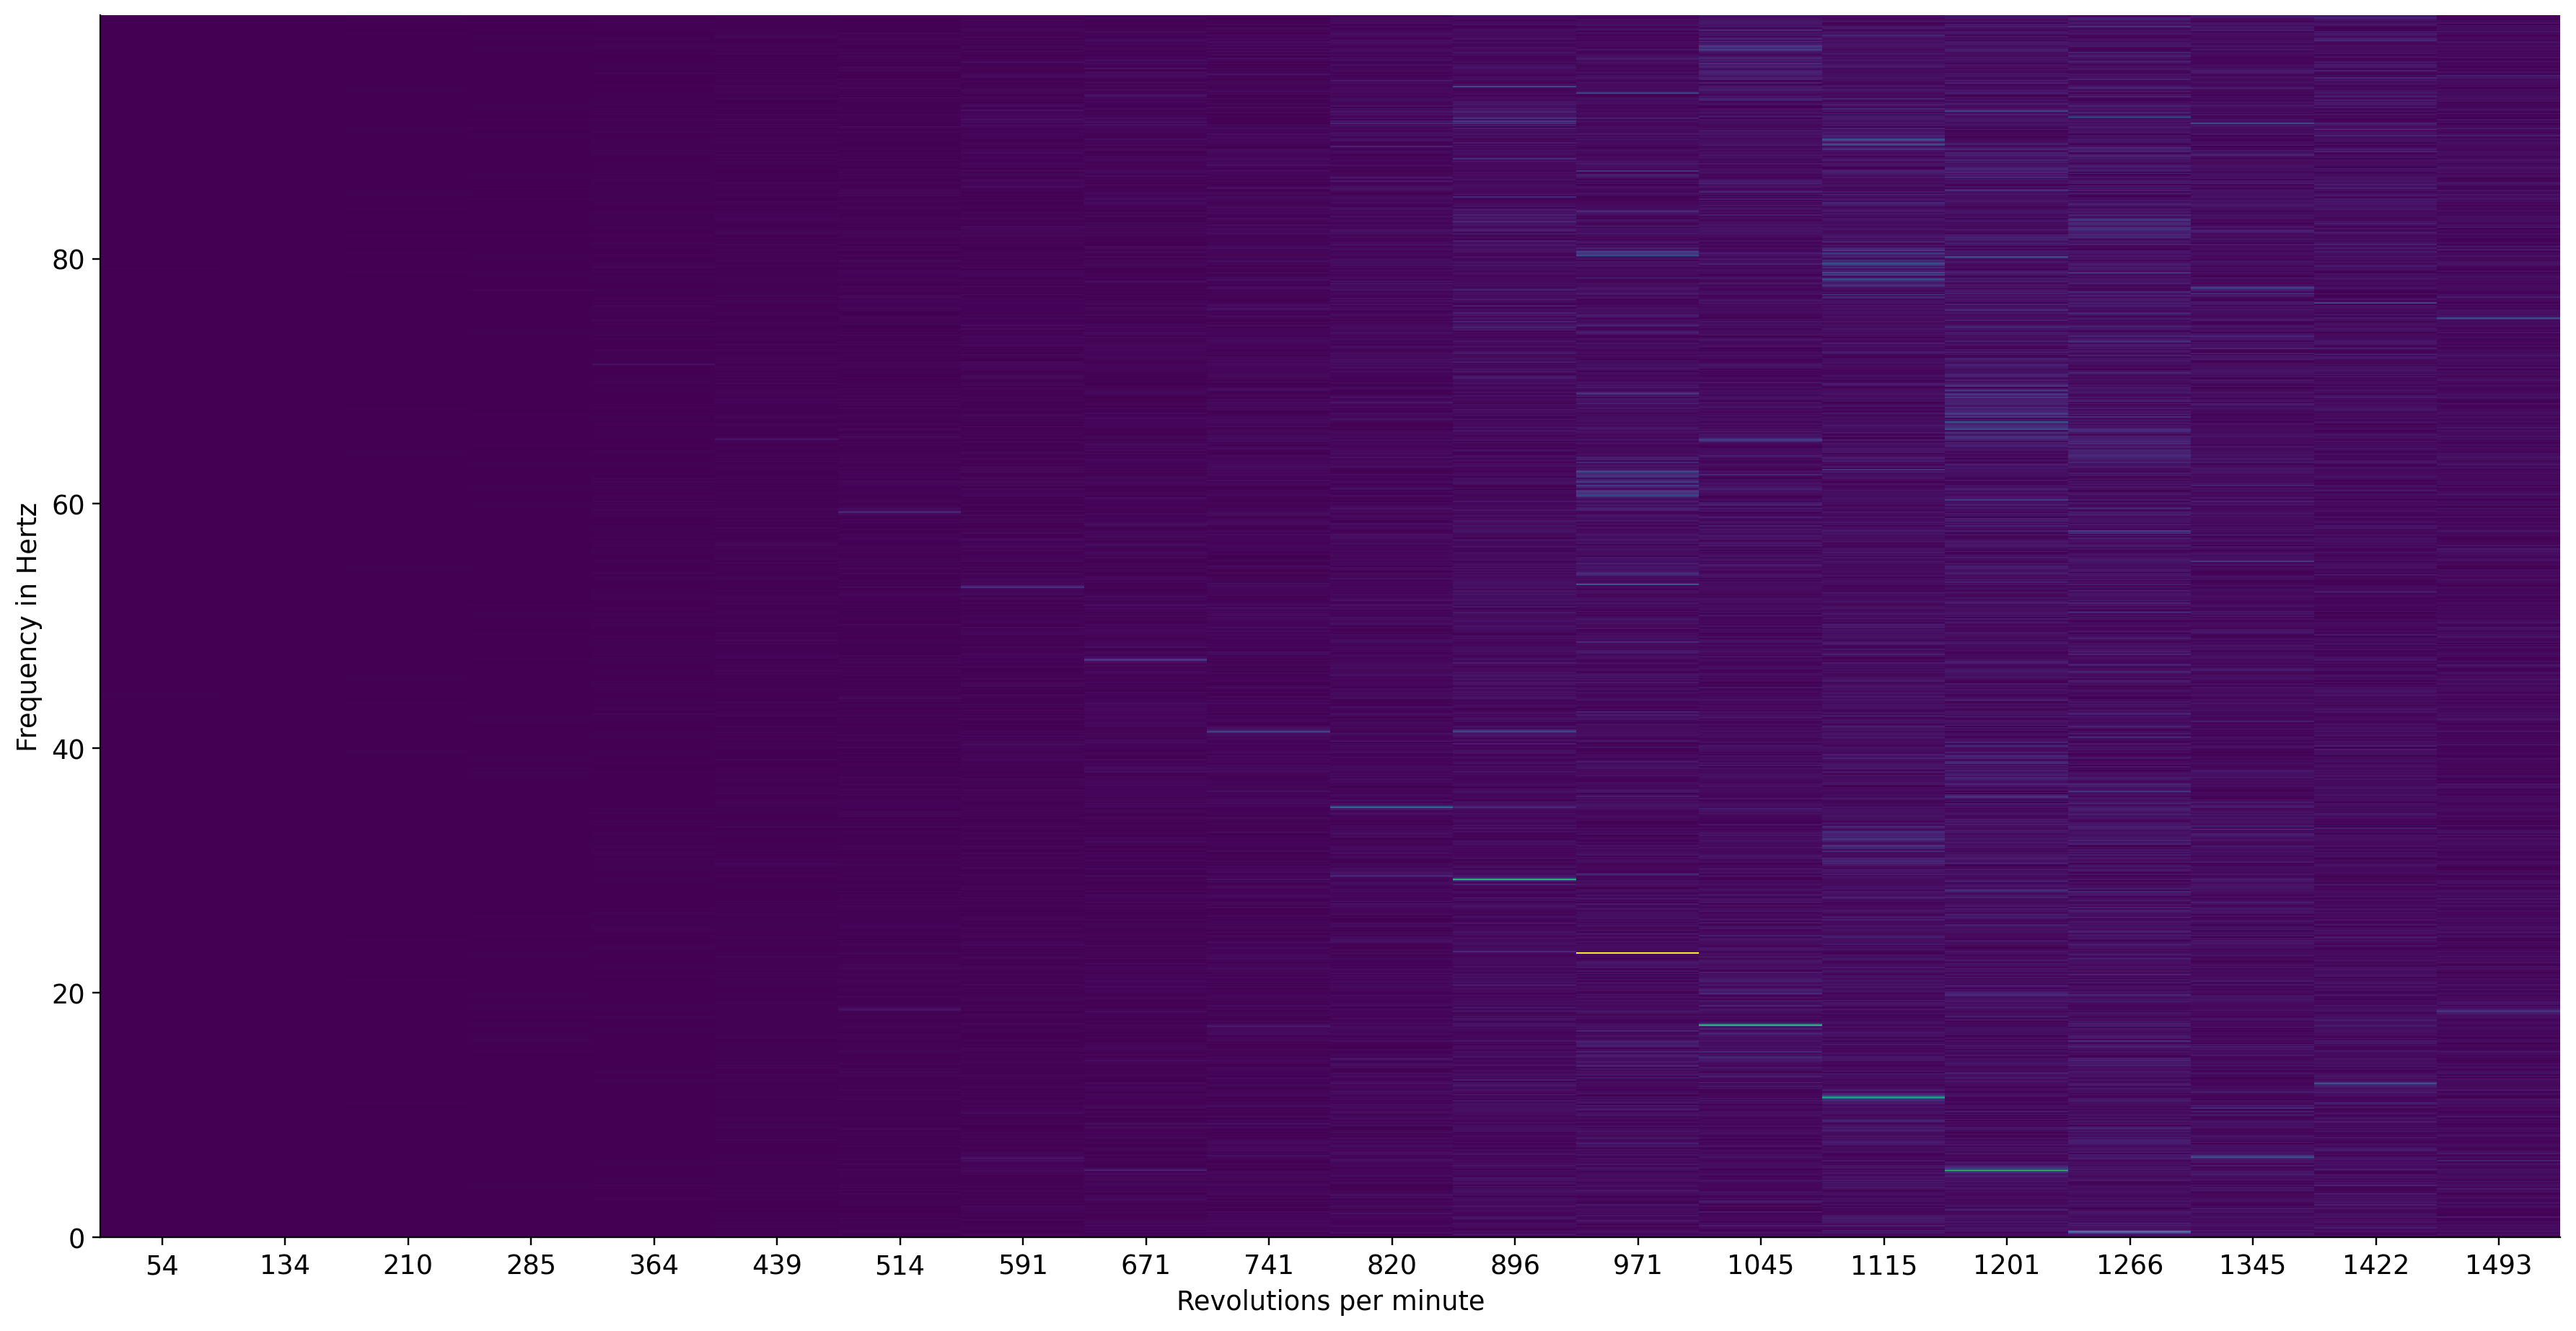

In [9]:
show_amplitudes = []
for i in range(len(amplitudes[0])):
    amplitudes_of_frequency = []    
    for z in range(len(amplitudes)):
        amplitudes_of_frequency.append(amplitudes[z][i])
    show_amplitudes.append(amplitudes_of_frequency)


plt.figure(figsize = (20,10))
plt.imshow(show_amplitudes, extent = (-0.5,len(RPM)-0.5,0,frequencies[len(frequencies)-1][len(frequencies[0])-1]), aspect = "auto", interpolation = "none")
plt.xticks(range(len(RPM)), RPM)
plt.xlabel("Revolutions per minute")
plt.ylabel("Frequency in Hertz")

## Dritter Datensatz: Prüfstand 03

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)
RPM = []
amplitudes = []
frequencies = []


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions

with h5py.File(path_measurement_folder + "/" + filename, "r") as measurement:
    for i in range(20):
        i = str(i)
        data = m_postprocessing.get_vec_accel(measurement[i]["RawData"][uuid_acceleration]["acceleration_x"], measurement[i]["RawData"][uuid_acceleration]["acceleration_y"], measurement[i]["RawData"][uuid_acceleration]["acceleration_z"])
        interpolated_data = m_postprocessing.interpolation(measurement[i]["RawData"][uuid_acceleration]["timestamp"], data, interpolation_points)
        [amp, freq] = m_postprocessing.my_fft_scaled(interpolated_data, measurement[i]["RawData"][uuid_acceleration]["timestamp"])
        RPM.append(measurement[i]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        amplitudes.append(amp)
        frequencies.append(freq)

#### 3. Darstellung mittels Campbell-Diagramm

Text(0, 0.5, 'Frequency in Hertz')

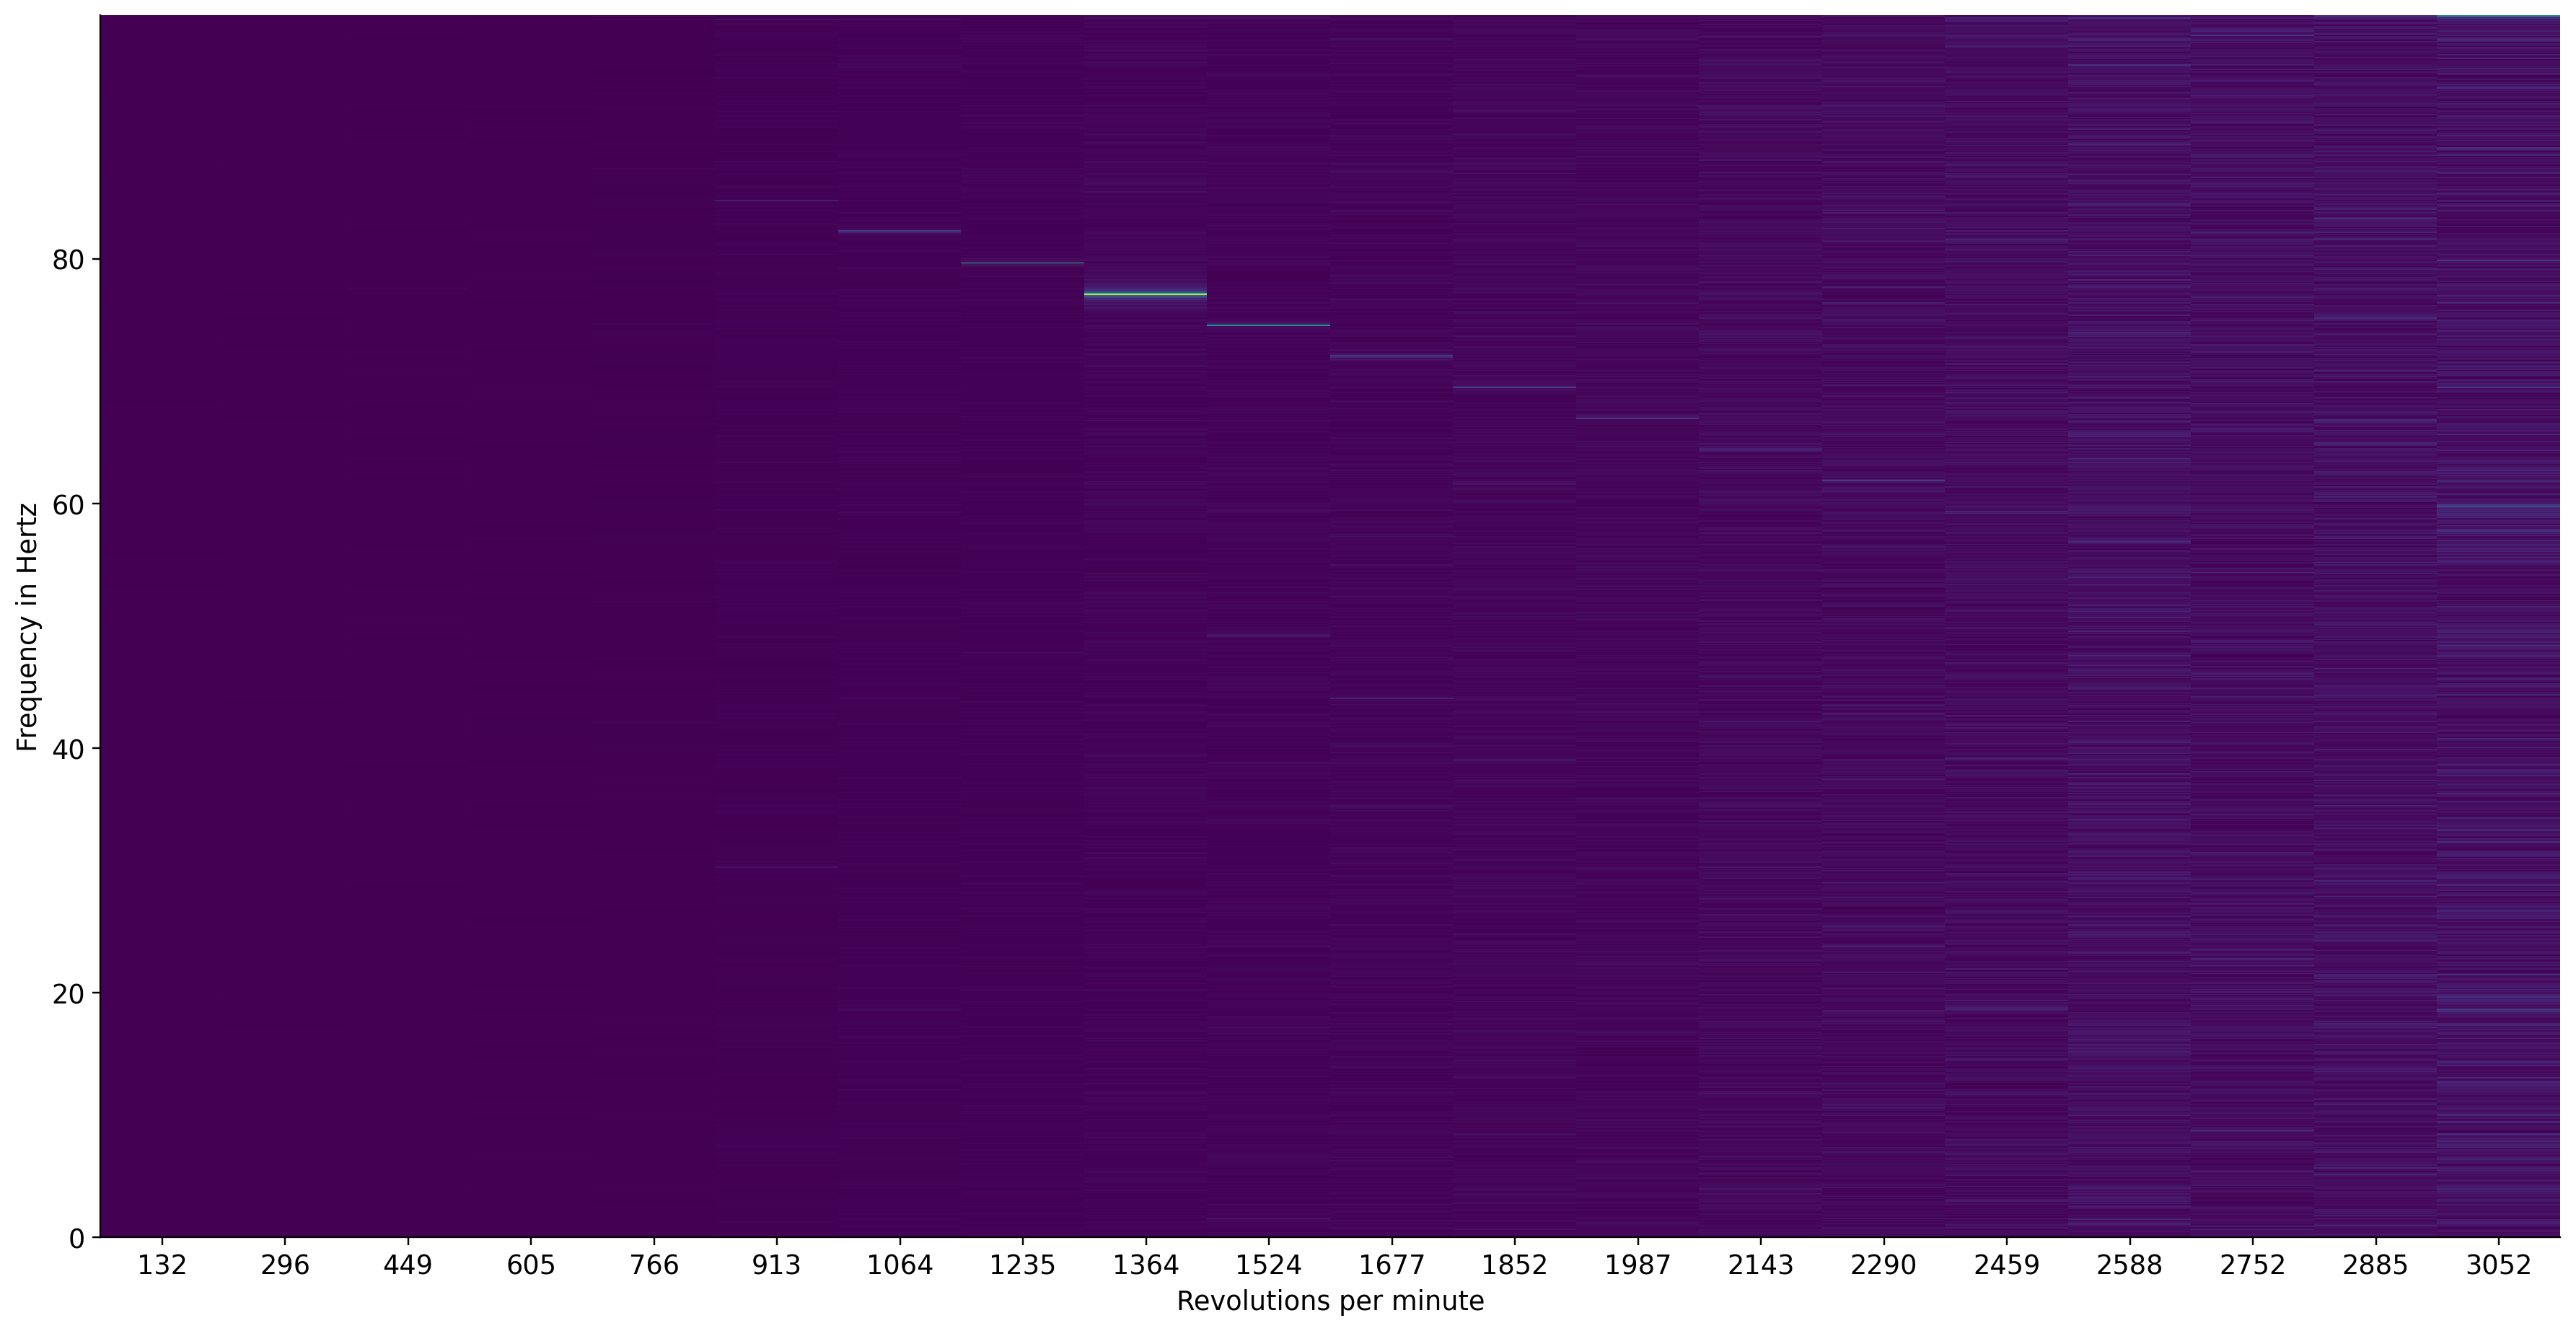

In [12]:
show_amplitudes = []
for i in range(len(amplitudes[0])):
    amplitudes_of_frequency = []    
    for z in range(len(amplitudes)):
        amplitudes_of_frequency.append(amplitudes[z][i])
    show_amplitudes.append(amplitudes_of_frequency)


plt.figure(figsize = (20,10))
plt.imshow(show_amplitudes, extent = (-0.5,len(RPM)-0.5,0,frequencies[len(frequencies)-1][len(frequencies[0])-1]), aspect = "auto", interpolation = "none")
plt.xticks(range(len(RPM)), RPM)
plt.xlabel("Revolutions per minute")
plt.ylabel("Frequency in Hertz")

Bei dem Campbell Diagramm zu Prüfstand 4 ist eine eindeutige kritische Kreisfrequenz von 734 Umdrehungen pro Minute zu erkennen. Bei den beiden anderen Prüfständen sind leider keine eindeutigen kritischen Kreisfrequenzen zu erkennen, auch wenn beide jeweils zwei besitzen sollten. Das liegt möglicherweise an Messungenauigkeiten oder einem Fehler in meinem Programm.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Wir kamen bei der Berechnung auf eine kritische Drehzahl von 661,875 Umdrehungen pro Minute . Unser Ergebnis ist also relativ nah an der gemessenen kritischen Drehzahl 734 Umdrehungen pro Minute. Die Abweichung lässt sich durch Messungenauigkeiten erklären und dadurch, dass die Drehzahlen relativ große Abstände zueinander haben. Bei Prüfstand 4 erfolgt über der kritischen Drehzahl eine Selbstzentrierung, die sich im Diagramm gut erkennen lässt. Danach hat der Prüfstand eine hohe rotordynamische Stabilität, welche zu sehr hohen Drehzahlen hin etwas abnimmt. Auch Prüfstand 3 hat eine hohe Stabilität. Prüfstand 2 hingegen hat zwischen ca. 896 und 1266 Umdrehungen pro Minute einen relativ kritischen Bereich, ist aber immer noch einigermaßen stabil.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Versuchsdurchführung selbst fand ich bei dem Versuch nicht sehr spannend, da diese Größtenteils aus warten bestand. Die Versuchsauswertung mit den Campbell-Diagrammen hingegen fand ich sehr interessant, da ich davor nicht wusste, wie man Diagramme dieser Art darstellen kann.